# Prjctr HW13. Time series analysis
1. Train a baseline predictions with different statistics and various time windows, validate and make predictions on test set.
2. Train a boosting model, validate and make predictions on test set. (optional)

https://www.kaggle.com/c/competitive-data-science-predict-future-sales/

In [1]:
#!pip install ydata-profiling ipywidgets

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

In [3]:
train_file = r'C:\Users\De\.kaggle\predict-future-sales\sales_train.csv'
test_file = r'C:\Users\De\.kaggle\predict-future-sales\test.csv'

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [4]:
print(train_data.info())
train_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [5]:
print(test_data.info())
# train_data['date_'] = pd.to_datetime(train_data.date, format='%d.%m.%Y').dt.date
test_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [6]:
train_data.isnull().sum(axis=0)

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [43]:
from ydata_profiling import ProfileReport
from datetime import datetime

train_data_report = ProfileReport(train_data, explorative=True)
train_data_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
date_block_num_boundaries = (train_data.date_block_num.min(), train_data.date_block_num.max())
date_block_num_range = np.array(range(train_data.date_block_num.min(), train_data.date_block_num.max() + 1))
print('date_block_num:', date_block_num_boundaries, date_block_num_range)
print('item_cnt_day:', train_data.item_cnt_day.min(), train_data.item_cnt_day.max())

train_data.item_cnt_day = train_data.item_cnt_day.clip(0,20).astype(int)
print('item_cnt_day:', train_data.item_cnt_day.min(), train_data.item_cnt_day.max())
# print('date:', train_data['date'].min(), train_data['date'].max())
# train_data.item_cnt_day.value_counts(normalize=True)


date_block_num: (0, 33) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
item_cnt_day: 0 20
item_cnt_day: 0 20


<Axes: >

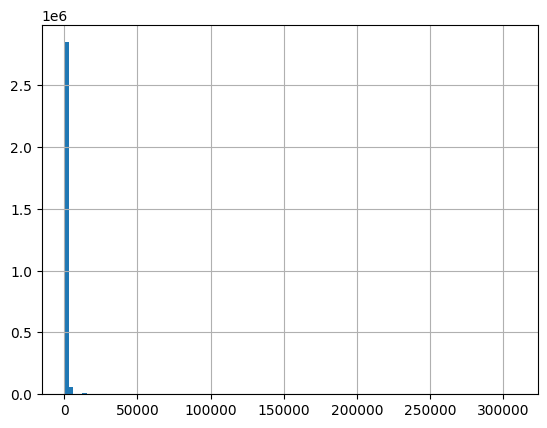

In [8]:
train_data['item_price'].hist(bins=100)

<Axes: >

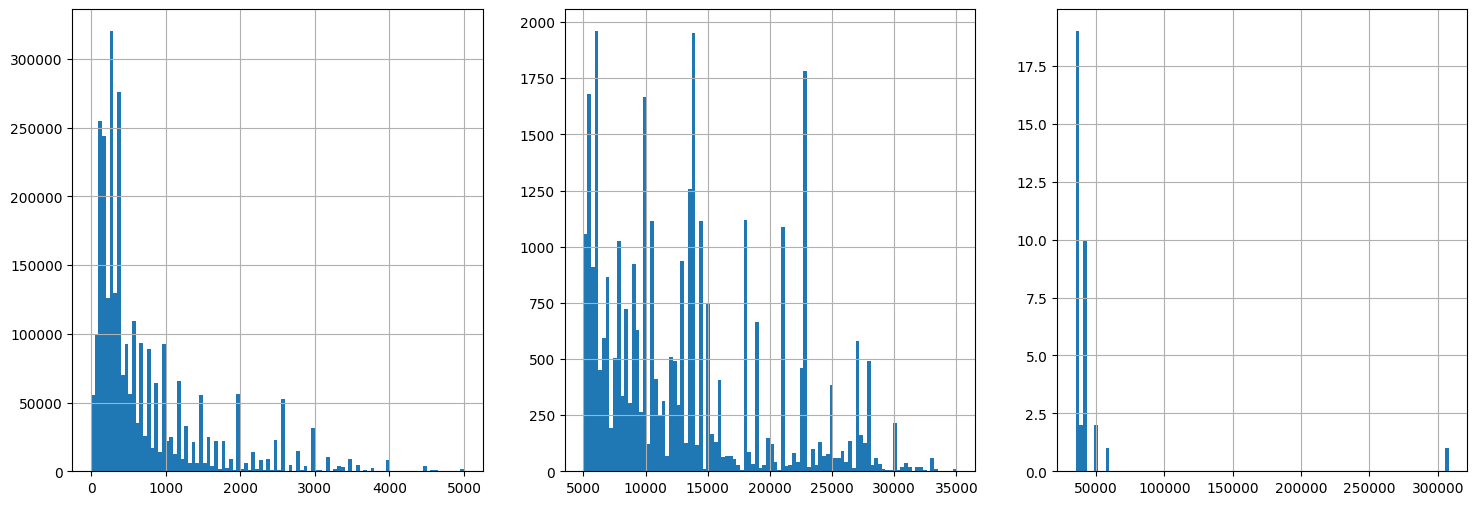

In [9]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
train_data[train_data['item_price'] < 5000]['item_price'].hist(bins=100)
plt.subplot(1, 3, 2)
train_data[(train_data['item_price'] >= 5000) & (train_data['item_price'] < 35000)]['item_price'].hist(bins=100)
plt.subplot(1, 3, 3)
train_data[train_data['item_price'] >= 35000]['item_price'].hist(bins=100)

In [10]:
grouping_fields = ["date_block_num", "shop_id", "item_id"]

In [14]:
def group_and_fill_zeros(df, grouping_fields):
    df = df.groupby(grouping_fields)["item_cnt_day"].sum().reset_index(name="item_cnt_month")

    shop_ids = df['shop_id'].unique()
    item_ids = df['item_id'].unique()
    month_nums = range(df['date_block_num'].min(), df['date_block_num'].max() + 1)
    
    all_combinations = pd.DataFrame(
        list(itertools.product(shop_ids, item_ids, month_nums)),
        columns=grouping_fields
    )
    
    df_full = pd.merge(all_combinations, df, on=grouping_fields, how='left')
    df_full['item_cnt_month'] = df_full['item_cnt_month'].fillna(0)
    
    return df_full

pickle_file_path = r'C:\Users\De\.kaggle\predict-future-sales\train_data_by_month.pkl'
train_data_by_month = None
if os.path.exists(pickle_file_path):
    train_data_by_month = pd.read_pickle(pickle_file_path)
else:
    train_data_by_month = group_and_fill_zeros(train_data, grouping_fields)
    train_data_by_month.to_pickle(pickle_file_path)

train_data_by_month

,date_block_num,shop_id,item_id,item_cnt_month
0,0,32,0,0.0
1,0,32,1,0.0
2,0,32,2,0.0
3,0,32,3,0.0
4,0,32,4,0.0
...,...,...,...,...
44486275,36,15925,29,0.0
44486276,36,15925,30,0.0
44486277,36,15925,31,0.0
44486278,36,15925,32,0.0


In [15]:
train_data_by_month_sample = train_data_by_month.sample(100000)

In [58]:
def predict_const(val_data: pd.DataFrame) -> pd.Series:
    return [0] * len(val_data)

def predict_as_previous_month(train_data, val_data):
    last_month = train_data.loc[train_data["date_block_num"] == train_data["date_block_num"].max()]
    last_month.rename(columns={"item_cnt_month": "prediction"}, inplace=True)
    last_month["date_block_num"] += 1
    val_data = val_data.merge(last_month, on=["date_block_num", "shop_id", "item_id"], how="left")
    return val_data

def predict_as_sliding_window(train_data, val_data, window: int = 3, agg_func: str = "mean"):
    period_train_data = train_data.loc[train_data["date_block_num"] > train_data["date_block_num"].max() - window]
    period_train_data = period_train_data.groupby(["shop_id", "item_id"])["item_cnt_month"].agg(agg_func).reset_index(name="prediction")
    val_data = val_data.merge(period_train_data, on=["shop_id", "item_id"], how="left")
    return val_data

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.metrics import mean_squared_error

validation_folds = [
    (range(26, 29), [29]),
    (range(26, 30), [30]),
    (range(26, 31), [31]),
    (range(26, 32), [32]),
    (range(26, 33), [33]),
]

for train_date_block_nums, val_date_block_nums in validation_folds:
    train_fold = date_shop_item_grid.loc[date_shop_item_grid["date_block_num"].isin(train_date_block_nums)]
    val_fold = date_shop_item_grid.loc[date_shop_item_grid["date_block_num"].isin(val_date_block_nums)]
    val_fold = predict_as_sliding_window(train_fold, val_fold, window=3, agg_func="median")
    metrics = mean_squared_error(val_fold["item_cnt_month"].clip(0,20), val_fold["prediction"].clip(0,20), squared=False)

    print(f"{val_date_block_nums}: {metrics: .2f}")
    
last_month = train_fold.loc[train_fold["date_block_num"] == train_fold["date_block_num"].max()]
last_month.rename(columns={"item_cnt_month": "prediction"}, inplace=True)
val_fold = val_fold.merge(last_month, on=["date_block_num", "shop_id", "item_id"], how="left")

def create_lag_features(target_data, all_data, lags_range, months_ahead):
    new_data = pd.DataFrame([])
    for month_ahead in range(months_ahead):
        month_ahead_data = target_data.copy()
        for lag in lags_range:
            all_data_copy = all_data.copy()
            all_data_copy["date_block_num"] += lag + month_ahead
            all_data_copy.rename(columns={"item_cnt_month": f"item_cnt_month_lag_{lag}"}, inplace=True)
            month_ahead_data = month_ahead_data.merge(all_data_copy, on=["shop_id", "item_id", "date_block_num"], how="left").fillna(0)
        month_ahead_data["month_ahead"] = month_ahead + 1
        new_data = pd.concat([new_data, month_ahead_data])
    return new_data

import lightgbm as lgb

parameters = {
    #default
    "objective": "regression_l2",
    "learning_rate": 0.1,
    "metric": "rmse",
    "seed": 42,

    #regularization
    "max_leaves": 32,
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "subsample_freq": 1,
    "min_data_in_leaf": 15
}

from copy import deepcopy

n_rounds = 150

lags_range = [1, 2, 3]
metrics_storage = []

for train_date_block_nums, val_date_block_nums in validation_folds:
    train_fold = date_shop_item_grid.loc[date_shop_item_grid["date_block_num"].isin(train_date_block_nums)]
    val_fold = date_shop_item_grid.loc[date_shop_item_grid["date_block_num"].isin(val_date_block_nums)]

    train_fold = create_lag_features(train_fold, date_shop_item_grid, lags_range, 1)
    val_fold = create_lag_features(val_fold, date_shop_item_grid, lags_range, 1)

    lgb_train = lgb.Dataset(train_fold[[f"item_cnt_month_lag_{lag}" for lag in lags_range]], label=train_fold["item_cnt_month"].clip(0, 20), free_raw_data=False)
    lgb_val = lgb.Dataset(val_fold[[f"item_cnt_month_lag_{lag}" for lag in lags_range]], label=val_fold["item_cnt_month"].clip(0, 20), free_raw_data=False)
    results = {}
    model_fold = lgb.train(parameters, lgb_train, n_rounds, valid_sets=(lgb_val, lgb_train), valid_names=("val", "train"), callbacks=[lgb.log_evaluation(period=1), lgb.record_evaluation(results)])
    metrics_storage.append(deepcopy(results))


import numpy as np

final_metrics = np.concatenate([np.array(metrics_storage[i]["val"]["rmse"]).reshape(150,1) for i in range(len(validation_folds))], axis=1)


final_metrics = pd.DataFrame(final_metrics, columns=[f"fold_{i}" for i in range(len(validation_folds))])
final_metrics["mean_rmse"] = final_metrics[[f"fold_{i}" for i in range(len(validation_folds))]].mean(axis=1)
final_metrics.iloc[final_metrics["mean_rmse"].argmin()]

np.concatenate([np.array(metrics_storage[i]["train"]["rmse"]).reshape(150,1) for i in range(len(validation_folds))], axis=1)[135, :]
train_fold = date_shop_item_grid.loc[date_shop_item_grid["date_block_num"].isin(range(26, 34))]

train_fold = create_lag_features(train_fold, date_shop_item_grid, lags_range, 1)

n_rounds = 135
lgb_train = lgb.Dataset(train_fold[[f"item_cnt_month_lag_{lag}" for lag in lags_range]], label=train_fold["item_cnt_month"].clip(0, 20), free_raw_data=False)
model = lgb.train(parameters, lgb_train, n_rounds)

test_data["prediction"] = model.predict(test_data[[f"item_cnt_month_lag_{lag}" for lag in lags_range]])

test_data[[f"item_cnt_month_lag_{lag}" for lag in lags_range]]

NameError: name 'train_data_by_month_sample' is not defined

In [ ]:
# repeat the training pipeline from workshop lecture
# make three submissions to the leaderboard to see how well the model is doing and if results are correlated with the local validation

In [ ]:
# replicate the approach as in the baseline
# you create the same features as for baseline (previous values for each shop_id-item_id pair)
# using the same validation train lightgbm model
# you should achieve better results than baseline (as we use the same features as baseline but apply lightgbm model instead of simple statistics)
# make predictions for the test set and submit them to the leaderboard

# to improve the solution you can try adding new features that were mentioned in the lecture

In [ ]:
def get_agg_columns(g):
    #last_user_active_time = g.loc[g['vm_state'] == 'UserActive', 'event_time'].max()
    #user_disconnected_time = g.loc[g['vm_state'] == 'UserDisconnected', 'event_time'].max()
    #user_logged_off_time = g.loc[g['vm_state'] == 'UserLoggedOff', 'event_time'].max()

    # if user_disconnected_time is not None and (
    #     last_user_active_time > user_disconnected_time or
    #     user_logged_off_time > user_disconnected_time):
    #     user_disconnected_time = None

    # if user_disconnected_time is not None and last_user_active_time > user_disconnected_time:
    #     user_disconnected_time = None

    #hardware_id = g['hardware_id'].first_valid_index()

    return pd.Series({
        'power_on_requested_time': g.loc[g['vm_state'] == 'PowerOnRequested', 'event_time'].min(),
        'booting_time': g.loc[g['vm_state'] == 'Booting', 'event_time'].min(),
        'office_activating_time': g.loc[g['vm_state'] == 'OfficeActivating', 'event_time'].min(),

        'application_ready_time': g.loc[g['vm_state'] == 'ApplicationReady', 'event_time'].min(),
        'user_active_time': g.loc[g['vm_state'] == 'UserActive', 'event_time'].min(),

        #'user_disconnected_time': user_disconnected_time,
        # 'user_logged_off_time': g.loc[g['vm_state'] == 'UserLoggedOff', 'event_time'].max(),

        'terminating_time': g.loc[g['vm_state'] == 'Terminating', 'event_time'].min(),
        'power_off_time': g.loc[g['vm_state'] == 'PoweredOff', 'event_time'].min(),

        'exhausted_time': g.loc[g['vm_state'] == 'Exhausted', 'event_time'].min(),
        'user_initialization_failed_time': g.loc[g['vm_state'] == 'UserInitializationFailed', 'event_time'].min(),
        'reset_required_time': g.loc[g['vm_state'] == 'ResetRequired', 'event_time'].min(),

        #'user_disconnected_count': g.loc[g['vm_state'] == 'UserDisconnected', 'event_time'].count(),
        #'hardware_id': hardware_id,

        'workflow': '->'.join(g['vm_state']),
    })

sessions = sessions.join(x_grouped.apply(get_agg_columns, include_groups=False))
